<a href="https://colab.research.google.com/github/scaairesearch/da_cv_fer/blob/main/for_aditya.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/scaairesearch/da_cv_fer.git
import os
os.getcwd()
os.chdir('da_cv_fer')

Cloning into 'da_cv_fer'...
remote: Enumerating objects: 367, done.
remote: Counting objects: 100% (158/158), done.
remote: Compressing objects: 100% (126/126), done.
remote: Total 367 (delta 78), reused 67 (delta 32), pack-reused 209
Receiving objects: 100% (367/367), 23.74 MiB | 16.57 MiB/s, done.
Resolving deltas: 100% (192/192), done.


In [2]:
!pip install -q -r requirements.txt # -q is for quiet install
# for some reason the below does not get installed with requirements
!pip install -q opendatasets
!pip install -q facenet_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.0/143.0 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.7/301.7 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.7/225.7 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.4/173.4 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
#@title loading libraries
from da_cv_fer.data_config import DataConfig
from da_cv_fer.ds_sfew import DatasetSFEW
from da_cv_fer.ds_sfew_crop import DatasetSFEWCROP
from da_cv_fer.ds_expw_crop import EXPWCROP
from da_cv_fer.ds_expw import EXPW
from da_cv_fer.utils import *
from da_cv_fer.model_DANN import DANN
from da_cv_fer.model_DANN_Bespoke import DANNBespoke
from da_cv_fer.run_config import RunConfig
from da_cv_fer.train import *
import os
import zipfile

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

from tqdm import tqdm # for beautiful model training updates

import matplotlib.pyplot as plt # for plots

import time
from pathlib import Path

from copy import deepcopy
import numpy as np


# importing libraries
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import collections
import cv2
import os

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cpu


In [6]:
#@title Loading models to evaluate
non_dann_model_sfew_name =  'non_dann_sfew_expw_14_03.pt'
dataconfig_inference = DataConfig()

In [7]:
non_dann_model_inference = DANNBespoke(num_classes=7, backbone='mobilenet', attention=False, dropout=0)
# model_dir = Path('/content/drive/MyDrive/SCAAI_FER/Models/non_dann_sfew_expw_14_03.pt')
model_dir = '/content/drive/MyDrive/CV_FER/models/non_dann_sfew_expw/non_dann_sfew_expw_14_03.pt'

try:
    non_dann_model_inference.load_state_dict(torch.load(model_dir, map_location=torch.device(device)))
    print(f'{model_dir} loaded successfully')
except Exception as e:
    print(f'Problem in loading {model_dir}: {e}')


Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 51.8MB/s]


feature extractor backbone created using mobilenet model
/content/drive/MyDrive/CV_FER/models/non_dann_sfew_expw/non_dann_sfew_expw_14_03.pt loaded successfully


In [ ]:
non_dann_model_inference.to(device)

In [ ]:
non_dann_model_inference.eval()

In [34]:
#@title # Step 2: Preprocess input images
def preprocess_image(image, device):
    # image = cv2.resize(image, (224, 224))  # Resize to match model input size
    # image = transforms.ToTensor()(image)  # Convert to tensor
    # image = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image)  # Normalize
    # print(image.shape, image)

    image = image / 255.0  # Normalize pixel values to [0, 1]
    image = image.unsqueeze(0)  # Add batch dimension
    image = image.to(device)  # Send tensor to device (CPU or GPU)
    return image

In [11]:
# Define a mapping from numerical index to emotion label
labels_map = {
    "0": "Angry",
    "1": "Disgust",
    "2": "Fear",
    "3": "Happy",
    "4": "Sad",
    "5": "Surprise",
    "6": "Neutral"
}

In [12]:
#@title # Step 3: Perform inference
def predict_emotion(image, model):
    with torch.no_grad():
        model.eval()  # Set model to evaluation mode
        output = model(image)
        prediction = output[0]  # Assuming the first element of the tuple is the prediction tensor

        print("##########################################################")
        print(output)
        print("##########################################################")

        _, predicted_index = torch.max(prediction, 1)
        predicted_label = labels_map[str(predicted_index.item())]  # Convert numerical index to emotion label
    return predicted_label

In [13]:
#@title # Step 4: Visualize predicted output on the image
def visualize_prediction(image, predicted_class):
    plt.imshow(image)
    plt.title(f'Predicted Emotion: {predicted_class}')
    plt.axis('off')
    plt.show()

In [14]:
#@title Cropped Images
# Load synthetic images
# synth_path = '/content/drive/MyDrive/SCAAI_FER/Synthetic Data/Testing_Data/testcrop'
synth_path = '/content/drive/MyDrive/CV_FER/dataset/synthetic_test_data_cropped'
synth_images = []
original_labels = []

for filename in os.listdir(synth_path):
    if filename.endswith(".png"):
      print(filename)
      img = cv2.imread(os.path.join(synth_path, filename))
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      img = cv2.resize(img, (224, 224))  # Resize image to a fixed size (e.g., 224x224)
      img_tensor = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)  # Convert to tensor and permute dimensions
      img_tensor = img_tensor.to(device)  # Move tensor to device
      synth_images.append(img_tensor)
      label = filename.split('_')[0]
      original_labels.append(label)

Angry_Man_Old.png
Disgust_Female_Makeup.png
Angry_Woman_Old.png
Disgust_Male_Cap.png
Fear_Male_Glasses.png
Fear_Female_Hijab.png
Happy_Male_Light.png
Neutral_Male_Asian.png
Happy_Woman_Old.png
Neutral_Woman_Jewels.png
Sad_Female_Tilt.png
Surprised_Child_African.png
Sad_Male_Indian.png
Surprised_Male_Asian.png


In [29]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def visualize_image(image_tensor):
  # Assuming 'image_tensor' is your image tensor with shape (3, 224, 224) and values between 0 and 255
  # Convert the tensor values to the range [0, 1] for visualization
  image_to_show = image_tensor / 255.0

  # Reorder the dimensions to (224, 224, 3) for visualization
  image_to_show = image_to_show.permute(1, 2, 0)

  # Visualize the image
  plt.imshow(image_to_show)
  plt.show()

image index 6
tensor([[[ 73.,  73.,  72.,  ...,  11.,   9.,   9.],
         [ 73.,  73.,  72.,  ...,  12.,  11.,  11.],
         [ 73.,  72.,  71.,  ...,  15.,  14.,  14.],
         ...,
         [248., 248., 250.,  ...,  12.,  11.,  11.],
         [247., 247., 249.,  ...,  12.,  12.,  12.],
         [247., 247., 249.,  ...,  12.,  12.,  12.]],

        [[ 54.,  54.,  52.,  ...,   6.,   4.,   4.],
         [ 54.,  54.,  52.,  ...,   6.,   5.,   5.],
         [ 55.,  55.,  53.,  ...,   7.,   7.,   7.],
         ...,
         [123., 123., 123.,  ...,   2.,   2.,   2.],
         [123., 123., 122.,  ...,   3.,   2.,   2.],
         [123., 123., 122.,  ...,   3.,   2.,   2.]],

        [[ 39.,  39.,  38.,  ...,   5.,   3.,   3.],
         [ 39.,  39.,  37.,  ...,   6.,   4.,   4.],
         [ 40.,  40.,  35.,  ...,   8.,   7.,   7.],
         ...,
         [ 11.,  11.,  13.,  ...,   2.,   2.,   2.],
         [ 11.,  11.,  12.,  ...,   3.,   3.,   3.],
         [ 11.,  11.,  12.,  ...,   4.,

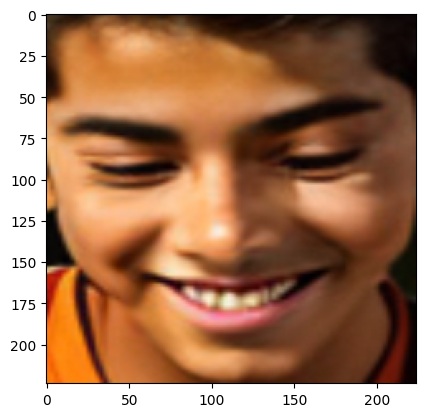

torch.Size([3, 224, 224]) tensor([[[ 73.,  73.,  72.,  ...,  11.,   9.,   9.],
         [ 73.,  73.,  72.,  ...,  12.,  11.,  11.],
         [ 73.,  72.,  71.,  ...,  15.,  14.,  14.],
         ...,
         [248., 248., 250.,  ...,  12.,  11.,  11.],
         [247., 247., 249.,  ...,  12.,  12.,  12.],
         [247., 247., 249.,  ...,  12.,  12.,  12.]],

        [[ 54.,  54.,  52.,  ...,   6.,   4.,   4.],
         [ 54.,  54.,  52.,  ...,   6.,   5.,   5.],
         [ 55.,  55.,  53.,  ...,   7.,   7.,   7.],
         ...,
         [123., 123., 123.,  ...,   2.,   2.,   2.],
         [123., 123., 122.,  ...,   3.,   2.,   2.],
         [123., 123., 122.,  ...,   3.,   2.,   2.]],

        [[ 39.,  39.,  38.,  ...,   5.,   3.,   3.],
         [ 39.,  39.,  37.,  ...,   6.,   4.,   4.],
         [ 40.,  40.,  35.,  ...,   8.,   7.,   7.],
         ...,
         [ 11.,  11.,  13.,  ...,   2.,   2.,   2.],
         [ 11.,  11.,  12.,  ...,   3.,   3.,   3.],
         [ 11.,  11.,  12.,

tensor([[[[0.2863, 0.2863, 0.2824,  ..., 0.0431, 0.0353, 0.0353],
          [0.2863, 0.2863, 0.2824,  ..., 0.0471, 0.0431, 0.0431],
          [0.2863, 0.2824, 0.2784,  ..., 0.0588, 0.0549, 0.0549],
          ...,
          [0.9725, 0.9725, 0.9804,  ..., 0.0471, 0.0431, 0.0431],
          [0.9686, 0.9686, 0.9765,  ..., 0.0471, 0.0471, 0.0471],
          [0.9686, 0.9686, 0.9765,  ..., 0.0471, 0.0471, 0.0471]],

         [[0.2118, 0.2118, 0.2039,  ..., 0.0235, 0.0157, 0.0157],
          [0.2118, 0.2118, 0.2039,  ..., 0.0235, 0.0196, 0.0196],
          [0.2157, 0.2157, 0.2078,  ..., 0.0275, 0.0275, 0.0275],
          ...,
          [0.4824, 0.4824, 0.4824,  ..., 0.0078, 0.0078, 0.0078],
          [0.4824, 0.4824, 0.4784,  ..., 0.0118, 0.0078, 0.0078],
          [0.4824, 0.4824, 0.4784,  ..., 0.0118, 0.0078, 0.0078]],

         [[0.1529, 0.1529, 0.1490,  ..., 0.0196, 0.0118, 0.0118],
          [0.1529, 0.1529, 0.1451,  ..., 0.0235, 0.0157, 0.0157],
          [0.1569, 0.1569, 0.1373,  ..., 0

In [33]:
import random
t = random.randint(0, len(synth_images))
print("image index",t)
print(synth_images[t])
print(torch.max(synth_images[t]))
print(synth_images[t].shape)
visualize_image(synth_images[t])
preprocess_image(synth_images[t],device=device)

##########################################################
(tensor([[ 2.4090,  2.9442, -2.8902, -2.3088, -1.4513, -0.7025,  1.1624]]), tensor([[-0.0678, -0.0110]]), tensor([[0.0516, 0.1173, 0.1769,  ..., 0.0220, 0.0124, 0.0000]]))
##########################################################
FILENAME:  Angry_Man_Old.png
ORIGINAL EMOTION:  Angry
PREDICTED EMOTION:  Disgust


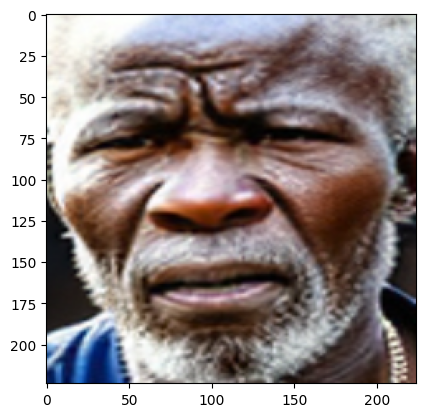

##########################################################
(tensor([[ 1.0273,  0.6286,  1.3756, -4.4149,  0.3592, -0.1853,  1.6762]]), tensor([[ 0.0096, -0.0710]]), tensor([[0.0000, 0.1566, 0.9320,  ..., 0.2220, 0.3596, 0.0211]]))
##########################################################
FILENAME:  Disgust_Female_Makeup.png
ORIGINAL EMOTION:  Disgust
PREDICTED EMOTION:  Neutral


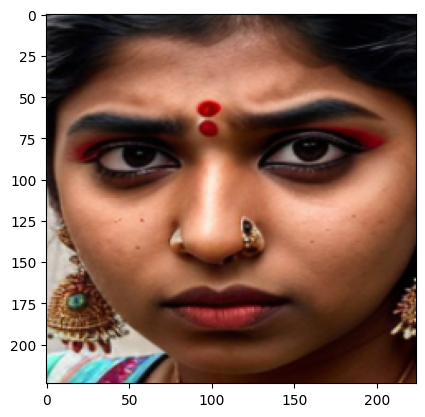

##########################################################
(tensor([[ 4.6001,  3.3055, -1.0937, -4.0001, -4.2454,  0.2475,  0.5567]]), tensor([[-0.0884, -0.0102]]), tensor([[0.1143, 0.3299, 0.1731,  ..., 0.0963, 0.3744, 0.0829]]))
##########################################################
FILENAME:  Angry_Woman_Old.png
ORIGINAL EMOTION:  Angry
PREDICTED EMOTION:  Angry


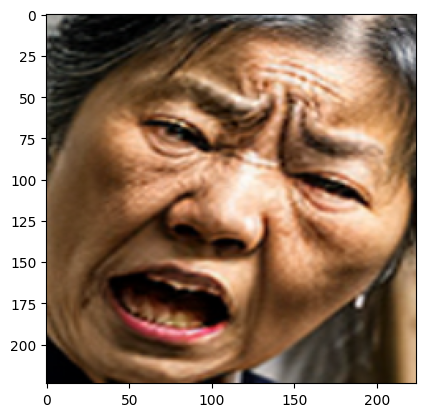

##########################################################
(tensor([[-0.4886,  1.3367,  0.7885, -2.5380, -0.2073, -0.4219,  1.5872]]), tensor([[-0.0296, -0.0919]]), tensor([[0.0000, 0.0000, 0.9990,  ..., 0.0000, 0.4178, 0.0000]]))
##########################################################
FILENAME:  Disgust_Male_Cap.png
ORIGINAL EMOTION:  Disgust
PREDICTED EMOTION:  Neutral


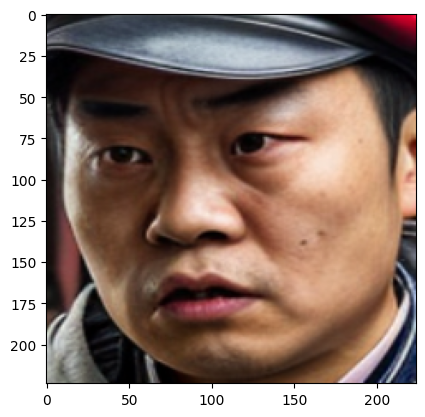

##########################################################
(tensor([[ 2.9756, -0.5181,  2.1715, -4.8562, -1.6783, -1.8234,  3.0752]]), tensor([[-0.0730, -0.0801]]), tensor([[0.0000, 0.6093, 1.6832,  ..., 0.0526, 0.1250, 0.0000]]))
##########################################################
FILENAME:  Fear_Male_Glasses.png
ORIGINAL EMOTION:  Fear
PREDICTED EMOTION:  Neutral


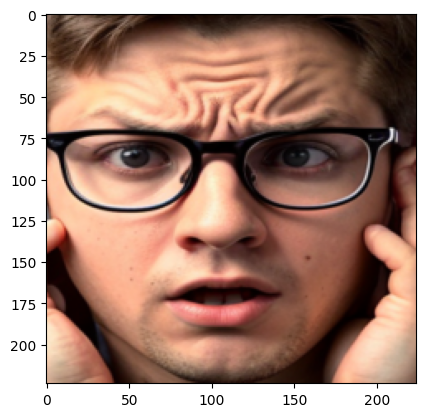

##########################################################
(tensor([[-1.1153, -1.6380, -0.0451, -2.6483,  0.9767,  0.6589,  3.8441]]), tensor([[-0.0172, -0.0853]]), tensor([[0.0000, 0.3927, 0.9529,  ..., 0.0435, 0.0931, 0.0000]]))
##########################################################
FILENAME:  Fear_Female_Hijab.png
ORIGINAL EMOTION:  Fear
PREDICTED EMOTION:  Neutral


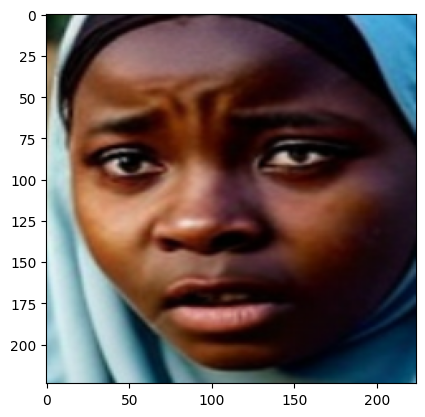

##########################################################
(tensor([[-0.2537, -1.0853, -5.0373, 10.3723, -1.6491, -1.7997, -1.8549]]), tensor([[0.1578, 0.0075]]), tensor([[0.9032, 0.0692, 0.1897,  ..., 0.1561, 0.1661, 0.0142]]))
##########################################################
FILENAME:  Happy_Male_Light.png
ORIGINAL EMOTION:  Happy
PREDICTED EMOTION:  Happy


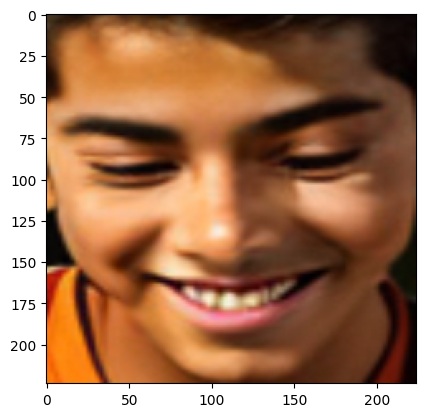

##########################################################
(tensor([[-2.4035, -2.3223, -0.2972, -3.6074,  4.3986,  2.7994,  2.4639]]), tensor([[-0.0379,  0.0174]]), tensor([[0.0000, 0.0000, 1.1203,  ..., 0.0000, 0.0267, 0.0404]]))
##########################################################
FILENAME:  Neutral_Male_Asian.png
ORIGINAL EMOTION:  Neutral
PREDICTED EMOTION:  Sad


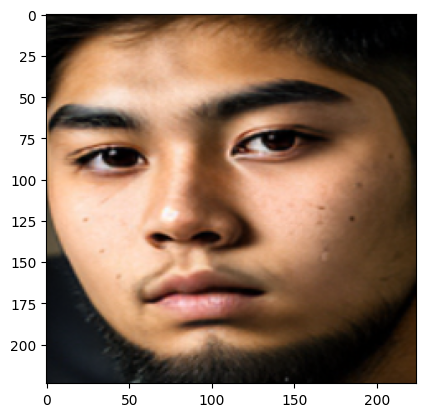

##########################################################
(tensor([[ 1.6293,  2.2338, -2.9500,  5.5546, -2.8307, -3.0724, -0.9901]]), tensor([[-0.0378,  0.0114]]), tensor([[0.0000, 0.0236, 0.0000,  ..., 0.2880, 0.2928, 0.0304]]))
##########################################################
FILENAME:  Happy_Woman_Old.png
ORIGINAL EMOTION:  Happy
PREDICTED EMOTION:  Happy


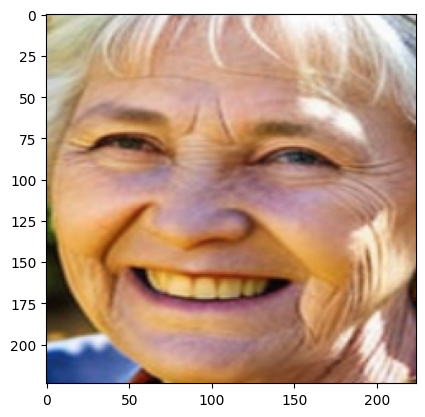

##########################################################
(tensor([[ 0.3590, -0.8293, -2.4287, -2.9618,  2.6762,  2.9456,  0.2942]]), tensor([[-0.0256, -0.0358]]), tensor([[0.1075, 0.1160, 0.8954,  ..., 0.1126, 0.6640, 0.0580]]))
##########################################################
FILENAME:  Neutral_Woman_Jewels.png
ORIGINAL EMOTION:  Neutral
PREDICTED EMOTION:  Surprise


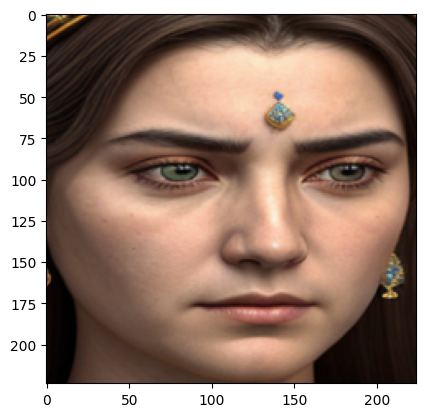

##########################################################
(tensor([[ 0.8619,  2.0587, -2.2032, -4.1309,  1.8739,  3.1422, -0.8215]]), tensor([[-0.0266, -0.0032]]), tensor([[0.3818, 0.0215, 0.6035,  ..., 0.0000, 0.7520, 0.0872]]))
##########################################################
FILENAME:  Sad_Female_Tilt.png
ORIGINAL EMOTION:  Sad
PREDICTED EMOTION:  Surprise


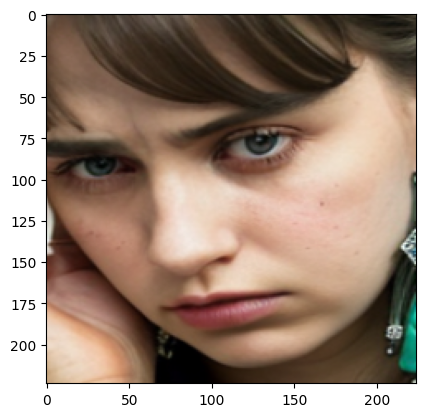

##########################################################
(tensor([[ 3.2870, -0.6369,  1.2610, -2.2327, -2.0943, -0.7363,  0.6893]]), tensor([[-0.0076, -0.1341]]), tensor([[0.0203, 0.0512, 0.1844,  ..., 0.0987, 0.6948, 0.1904]]))
##########################################################
FILENAME:  Surprised_Child_African.png
ORIGINAL EMOTION:  Surprised
PREDICTED EMOTION:  Angry


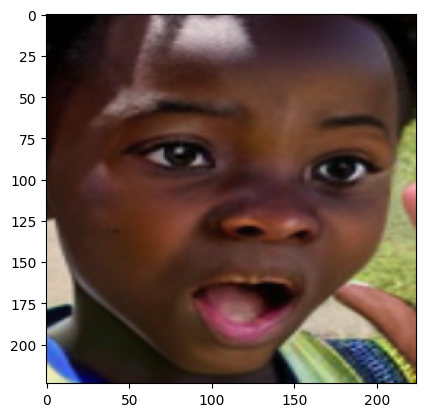

##########################################################
(tensor([[-0.0337, -0.0852,  2.7118, -3.2621, -0.5806,  1.0449,  0.7319]]), tensor([[ 0.0095, -0.0775]]), tensor([[0.0000, 0.0058, 1.1374,  ..., 0.0000, 0.6010, 0.0000]]))
##########################################################
FILENAME:  Sad_Male_Indian.png
ORIGINAL EMOTION:  Sad
PREDICTED EMOTION:  Fear


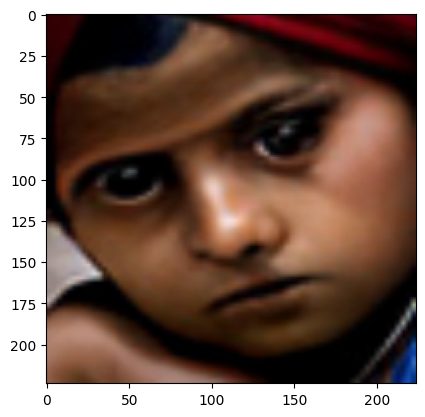

##########################################################
(tensor([[-0.4573, -1.4529,  2.7984, -4.8417, -0.5287,  1.4093,  3.8390]]), tensor([[-0.0843, -0.0643]]), tensor([[0.0000, 0.0000, 0.3894,  ..., 0.0561, 0.1249, 0.0000]]))
##########################################################
FILENAME:  Surprised_Male_Asian.png
ORIGINAL EMOTION:  Surprised
PREDICTED EMOTION:  Neutral


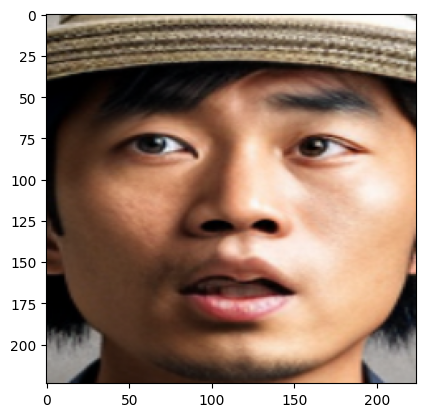

Accuracy: 0.21428571428571427
Precision: 0.21428571428571427
Confusion Matrix:
[[1 1 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0]
 [0 0 0 0 2 0 0 0]
 [0 0 0 2 0 0 0 0]
 [0 0 0 0 0 1 1 0]
 [0 0 1 0 0 0 1 0]
 [0 0 0 0 0 0 0 0]
 [1 0 0 0 1 0 0 0]]
Classification Report:
              precision    recall  f1-score   support

       Angry       0.50      0.50      0.50         2
     Disgust       0.00      0.00      0.00         2
        Fear       0.00      0.00      0.00         2
       Happy       1.00      1.00      1.00         2
     Neutral       0.00      0.00      0.00         2
         Sad       0.00      0.00      0.00         2
    Surprise       0.00      0.00      0.00         0
   Surprised       0.00      0.00      0.00         2

    accuracy                           0.21        14
   macro avg       0.19      0.19      0.19        14
weighted avg       0.21      0.21      0.21        14



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: Unde

In [35]:
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, classification_report

# Initialize lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Pick one image for prediction
for i in range(len(os.listdir(synth_path))):
    image_to_predict = synth_images[i]
    preprocessed_image = preprocess_image(image_to_predict, device)
    predicted_emotion = predict_emotion(preprocessed_image, non_dann_model_inference)

    # Get the true label from the filename
    true_label = original_labels[i]

    # Store true and predicted labels
    true_labels.append(true_label)
    predicted_labels.append(predicted_emotion)

    print("FILENAME: ", os.listdir(synth_path)[i])
    print("ORIGINAL EMOTION: ", true_label)
    print("PREDICTED EMOTION: ", predicted_emotion)
    visualize_image(image_to_predict)
    # print("xxxx", image_to_predict)
    # print("yyyy", preprocessed_image)
    # visualize_image(image_to_predict)

    # visualize_prediction(image_to_predict, predicted_emotion)
    # display.display(preprocessed_image)
    # print()

# Compute accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

# Compute precision
precision = precision_score(true_labels, predicted_labels, average='weighted')
print("Precision:", precision)

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(true_labels, predicted_labels)
print("Classification Report:")
print(class_report)
